In [84]:
Alpha_Name = "AlphaNet_Original_Input_10d_return"
start_time = "2021-01-01"
forecast_months = 6 # months
feat_num = 9
sequence = 3

In [85]:
from os import walk
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from progressbar import ProgressBar
from tqdm import tqdm
import torch.utils.data as Data
import torch.optim as optim
from tqdm import tqdm
from torch.autograd import Variable
import time
import multiprocessing as mp
from os import walk
import matplotlib.pyplot as plt
path = '/home/wuwenjun/Data/' + Alpha_Name +'/'
output_path = "/home/wuwenjun/Alpha_Factor/" + "LSTM_" + Alpha_Name + "/result/"
model_dir = "/home/wuwenjun/Alpha_Factor/" + "LSTM_" + Alpha_Name + "/model/"
input_length = feat_num * (feat_num - 1) + 4 * feat_num
if os.path.exists(output_path) == False:
    os.makedirs(output_path)
    print(output_path)

In [86]:
time_list = []
data_path = path + "Final/"
dataframe_list = pd.DataFrame()
for f, _, i in walk(data_path):
    for j in tqdm(i):
        time_list.append(j)
time_list.sort()     
for count,item in enumerate(time_list):
    if item.startswith(start_time):
        train_timestamp = time_list[:count]
        test_timestamp = time_list[count:count + forecast_months//3]
        break
display(train_timestamp)
display(test_timestamp)

model_path = (model_dir + test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1]).replace(".par","/")
if os.path.exists(model_path) == False:
    os.makedirs(model_path)
    print(model_path)

100%|██████████| 26/26 [00:00<00:00, 192331.40it/s]


['2015-01-01_2015-03-01.par',
 '2015-03-01_2015-06-01.par',
 '2015-06-01_2015-09-01.par',
 '2015-09-01_2016-01-01.par',
 '2016-01-01_2016-03-01.par',
 '2016-03-01_2016-06-01.par',
 '2016-06-01_2016-09-01.par',
 '2016-09-01_2017-01-01.par',
 '2017-01-01_2017-03-01.par',
 '2017-03-01_2017-06-01.par',
 '2017-06-01_2017-09-01.par',
 '2017-09-01_2018-01-01.par',
 '2018-01-01_2018-03-01.par',
 '2018-03-01_2018-06-01.par',
 '2018-06-01_2018-09-01.par',
 '2018-09-01_2019-01-01.par',
 '2019-01-01_2019-03-01.par',
 '2019-03-01_2019-06-01.par',
 '2019-06-01_2019-09-01.par',
 '2019-09-01_2020-01-01.par',
 '2020-01-01_2020-03-01.par',
 '2020-03-01_2020-06-01.par',
 '2020-06-01_2020-09-01.par',
 '2020-09-01_2021-01-01.par']

['2021-01-01_2021-03-01.par', '2021-03-01_2021-06-01.par']

/home/wuwenjun/Alpha_Factor/LSTM_AlphaNet_Original_Input_10d_return/model/2021-01-01_2021-06-01/


In [87]:
trainx , trainy , testx , testy = [] , [] , [],  []

for train in tqdm(train_timestamp):
    df = pd.read_parquet(path+ "Final/" + train).set_index(["timestamp","ticker"])
    trainx.append(df.drop("target",axis=1))
    trainy.append(df['target'])
trainx = pd.concat(trainx,axis=0)
trainy = pd.concat(trainy,axis=0)

display(trainx)
display(trainy)


for test in tqdm(test_timestamp):
    df = pd.read_parquet(path+ "Final/" + test).set_index(["timestamp","ticker"])
    testx.append(df.drop("target",axis=1))
    testy.append(df['target'])
testx = pd.concat(testx,axis=0)
testy = pd.concat(testy,axis=0)
target_list = pd.DataFrame(testy.copy())
display(testx)
display(testy)

100%|██████████| 24/24 [00:36<00:00,  1.52s/it]


,,0,1,2,3,4,5,6,7,8,9,...,314,315,316,317,318,319,320,321,322,323
timestamp,ticker,,,,,,,,,,,,,,,,,,,,,
2015-02-16 09:30:00,1,1047.509016,165.116922,249.851660,924.464829,243.390500,183.194222,926.891342,158.088300,78.887819,957.587687,...,861850.412364,0.138453,-0.376716,0.284385,1.522075,1.245018,0.876160,3.017927,2.468587,1.737222
2015-02-17 09:30:00,1,1284.106922,304.746632,233.319300,1251.132811,325.347890,190.544389,1311.161194,268.878420,78.529422,1262.525551,...,825372.445636,-1.631951,-0.601635,0.240629,1.601496,1.147820,0.839082,3.175407,2.275878,1.663689
2015-02-25 09:30:00,1,1515.538580,320.840611,242.242430,1522.025569,325.437271,214.401980,1539.154187,259.118036,99.405562,1482.690747,...,784033.056545,-1.377793,-0.151133,0.292173,1.574869,1.078356,0.797058,3.122595,2.138158,1.580369
2015-02-26 09:30:00,1,1466.712161,355.378729,244.332118,1546.573639,318.650776,222.730596,1381.349806,297.507667,108.085628,1469.916341,...,727636.666545,-0.375218,-0.482991,0.038896,1.643798,1.006125,0.739729,3.259280,1.994944,1.466684
2015-02-27 09:30:00,1,1271.480107,335.406489,121.012389,1338.104279,252.973056,186.957378,1296.812044,215.993378,108.132489,1324.356569,...,756908.456182,-0.411738,-0.287113,0.381687,1.581575,1.159289,0.769491,3.135918,2.298631,1.525691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25 09:30:00,688981,0.376847,0.558021,7.531216,0.289600,0.857656,8.524438,0.415018,0.554211,7.358793,0.274589,...,346090.446727,-0.797787,0.426938,-0.979651,2.151998,3.405911,3.327036,2.151998,3.405911,3.327036
2020-12-28 09:30:00,688981,0.875378,0.480857,6.125189,0.763667,0.835368,6.400609,0.808300,0.502249,5.499779,0.747445,...,315999.365091,-0.612075,0.348475,-0.959076,2.035465,3.520044,3.037771,2.035465,3.520044,3.037771
2020-12-29 09:30:00,688981,0.713691,0.488609,3.956496,0.914182,0.635866,3.450882,0.796116,0.431834,3.023371,0.773336,...,296250.213636,-0.408900,0.171973,-1.200438,2.207042,3.282189,2.847920,2.207042,3.282189,2.847920


timestamp            ticker
2015-02-16 09:30:00  1        -1.020014
2015-02-17 09:30:00  1        -0.796300
2015-02-25 09:30:00  1        -0.606755
2015-02-26 09:30:00  1        -0.363449
2015-02-27 09:30:00  1         0.047813
                                 ...   
2020-12-25 09:30:00  688981    1.980807
2020-12-28 09:30:00  688981    2.091656
2020-12-29 09:30:00  688981    2.066666
2020-12-30 09:30:00  688981    2.100103
2020-12-31 09:30:00  688981    1.563590
Name: target, Length: 4733596, dtype: float64

100%|██████████| 2/2 [00:05<00:00,  2.74s/it]


,,0,1,2,3,4,5,6,7,8,9,...,314,315,316,317,318,319,320,321,322,323
timestamp,ticker,,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:30:00,1,2086.209700,638.760711,2388.873944,1660.385500,562.793773,2197.613756,979.699228,517.784767,2115.005672,1682.629977,...,9.133615e+05,0.112375,0.059224,0.831236,0.480658,0.385069,0.470660,1.084467,0.868782,1.061904
2021-01-05 09:30:00,1,1225.113118,308.659348,2427.906478,1029.933871,138.327729,2365.284467,348.112816,36.047620,2280.152028,963.490433,...,1.030657e+06,-0.179338,-0.452380,0.094753,0.480655,0.412522,0.531104,1.084465,0.930724,1.198276
2021-01-06 09:30:00,1,1123.065644,283.267374,2433.073400,824.460522,242.783073,2378.538107,697.751556,199.968389,2261.251424,968.121446,...,1.187514e+06,-0.591845,-0.442833,-0.353407,0.476978,0.424169,0.611942,1.076158,0.957016,1.380649
2021-01-07 09:30:00,1,1914.092007,405.069927,1960.309756,1405.396413,443.601253,2437.533246,1376.581822,555.128400,1545.061384,1702.990270,...,1.348398e+06,-0.719236,-0.760849,1.043780,0.461584,0.446925,0.694847,1.041444,1.008373,1.567691
2021-01-08 09:30:00,1,2675.787573,1139.499867,2455.506700,1835.235471,849.026609,3196.175591,2044.546887,1069.184296,2244.427721,2275.057167,...,1.429031e+06,-0.659202,-0.580753,1.189207,0.441842,0.440676,0.736389,0.996896,0.994285,1.661433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25 09:30:00,688981,0.491390,0.330376,0.597377,0.378376,0.333682,0.604684,0.207140,0.161098,0.258099,0.441615,...,1.546051e+05,-0.624627,-0.272873,0.108298,1.831876,1.367515,1.411073,1.831876,1.367515,1.411073
2021-05-26 09:30:00,688981,0.366808,0.503432,0.422536,0.317736,0.462686,0.495469,0.250582,0.262870,0.149411,0.346992,...,1.622029e+05,-0.321055,-0.321316,0.212307,1.775511,1.287460,1.480416,1.775511,1.287460,1.480416
2021-05-27 09:30:00,688981,0.394747,0.451264,0.432110,0.267280,0.446866,0.399076,0.231393,0.129168,0.204787,0.333588,...,1.627918e+05,-0.316825,0.280824,0.012542,1.676253,1.451789,1.485793,1.676253,1.451789,1.485793


timestamp            ticker
2021-01-04 09:30:00  1         2.080068
2021-01-05 09:30:00  1         2.542624
2021-01-06 09:30:00  1         2.731188
2021-01-07 09:30:00  1         1.487784
2021-01-08 09:30:00  1         0.894896
                                 ...   
2021-05-25 09:30:00  688981   -0.262939
2021-05-26 09:30:00  688981   -0.222002
2021-05-27 09:30:00  688981   -0.212631
2021-05-28 09:30:00  688981   -0.232948
2021-05-31 09:30:00  688981   -0.320272
Name: target, Length: 402680, dtype: float64

In [88]:
# Reshape
trainx = torch.from_numpy(np.array(trainx).reshape(-1,input_length,sequence))
trainy = torch.from_numpy(np.array(trainy).reshape(-1,1))
testx = torch.from_numpy(np.array(testx).reshape(-1,input_length,sequence))
testy = torch.from_numpy(np.array(testy).reshape(-1,1))
print("trainx.shape: " , trainx.shape)
print("trainy.shape: " , trainy.shape)
print("testx.shape: " , testx.shape)
print("testy.shape: " , testy.shape)

trainx.shape:  torch.Size([4733596, 108, 3])
trainy.shape:  torch.Size([4733596, 1])
testx.shape:  torch.Size([402680, 108, 3])
testy.shape:  torch.Size([402680, 1])


In [89]:
train_dataset = Data.TensorDataset(trainx, trainy)
test_dataset = Data.TensorDataset(testx, testy)
batch_size = 1024
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=16,
    pin_memory=True
)

test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=16,
    pin_memory=True
)

In [90]:
class AlphaNet_LSTM(nn.Module):
    def __init__(self, factor_num, fully_connect_layer_neural):
        super(AlphaNet_LSTM, self).__init__()
        self.fc1_neuron = factor_num # 108
        self.fc2_neuron = fully_connect_layer_neural # 30
        
        # Layer
        self.batch = torch.nn.BatchNorm1d(self.fc1_neuron)
        self.lstm = nn.LSTM(self.fc1_neuron,self.fc2_neuron,2,batch_first = True,bidirectional = True)
        self.batch2 = torch.nn.BatchNorm1d(self.fc2_neuron)
        self.dropout = nn.Dropout(0.3)
#         self.relu = nn.ReLU()
        self.out = nn.Linear(self.fc2_neuron, 1)

    def forward(self, x):
        x = self.batch(x)
        x = torch.transpose(x,1,2)
        _,(hn, cn) = self.lstm(x) # hn.shape: torch.Size([4, 512, 30])
        hn = hn[-1,:,:] # torch.Size([512, 30])
        hn = self.batch2(hn) # torch.Size([512, 30])
#         hn = self.relu(hn)
        hn = self.dropout(hn)
        y_pred = self.out(hn)
        return y_pred
# device=torch.device('cuda:0')

In [91]:
alphanet = AlphaNet_LSTM(input_length, 30)
alphanet = alphanet.cuda()
# alphanet = torch.nn.parallel.DataParallel(alphanet)
print(alphanet)
total_length = trainx.shape[0]
LR = 0.01
loss_function = nn.MSELoss().cuda()
optimizer = optim.Adam(alphanet.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma = 0.5)
epoch_num = 20
loss_list = []

min_loss = float("inf")
for epoch in tqdm(range(epoch_num)):
    total_loss = 0
    for _, (inputs, outputs) in enumerate(train_loader):
        inputs = Variable(inputs).float().cuda()
        outputs = Variable(outputs).float().cuda()
        optimizer.zero_grad() # noticed:  the grad return to zero before starting the loop
        
        # forward + backward +update
        pred = alphanet(inputs)
        pred = pred.cuda()
        loss = loss_function(pred, outputs)
        loss.backward()
        optimizer.step()
        
#         lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        total_loss += loss.item()
    total_loss = total_loss * batch_size / total_length
    print('Epoch: ', epoch + 1, ' loss: ', total_loss)
    loss_list.append(total_loss)
    if total_loss < min_loss:
        torch.save(alphanet,model_path + "best_model.tar")
    np.save(model_path + "loss.npy", loss_list)
torch.save(alphanet,model_path + "model.tar")

  0%|          | 0/30 [00:00<?, ?it/s]

AlphaNet_LSTM(
  (batch): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(108, 30, num_layers=2, batch_first=True, bidirectional=True)
  (batch2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=30, out_features=1, bias=True)
)


  3%|▎         | 1/30 [00:54<26:23, 54.62s/it]

Epoch:  1  loss:  0.8320801560720251


  7%|▋         | 2/30 [01:49<25:41, 55.06s/it]

Epoch:  2  loss:  0.7957789006850167


 10%|█         | 3/30 [02:51<26:10, 58.17s/it]

Epoch:  3  loss:  0.791668439923237


 13%|█▎        | 4/30 [03:44<24:16, 56.02s/it]

Epoch:  4  loss:  0.7889849336712356


 17%|█▋        | 5/30 [05:31<31:00, 74.44s/it]

Epoch:  5  loss:  0.787216475955859


 20%|██        | 6/30 [06:34<28:07, 70.33s/it]

Epoch:  6  loss:  0.7855619992088533


 23%|██▎       | 7/30 [07:30<25:13, 65.79s/it]

Epoch:  7  loss:  0.7840428392815024


 27%|██▋       | 8/30 [08:58<26:40, 72.76s/it]

Epoch:  8  loss:  0.7828164042934075


 30%|███       | 9/30 [09:55<23:49, 68.07s/it]

Epoch:  9  loss:  0.7817871931243413


 33%|███▎      | 10/30 [11:46<27:04, 81.22s/it]

Epoch:  10  loss:  0.7807270451275763


 37%|███▋      | 11/30 [13:10<25:59, 82.10s/it]

Epoch:  11  loss:  0.7800084730458776


 40%|████      | 12/30 [14:33<24:43, 82.43s/it]

Epoch:  12  loss:  0.779056158515145


 43%|████▎     | 13/30 [15:30<21:07, 74.58s/it]

Epoch:  13  loss:  0.7784016257839895


 47%|████▋     | 14/30 [16:22<18:06, 67.90s/it]

Epoch:  14  loss:  0.7777312043772291


 50%|█████     | 15/30 [17:13<15:38, 62.59s/it]

Epoch:  15  loss:  0.7771480632145078


 53%|█████▎    | 16/30 [18:43<16:34, 71.06s/it]

Epoch:  16  loss:  0.7765599002503486


 57%|█████▋    | 17/30 [20:22<17:11, 79.32s/it]

Epoch:  17  loss:  0.7760024647792171


 60%|██████    | 18/30 [21:46<16:10, 80.85s/it]

Epoch:  18  loss:  0.7754861042261545


 63%|██████▎   | 19/30 [22:39<13:15, 72.30s/it]

Epoch:  19  loss:  0.7749327830742218


 67%|██████▋   | 20/30 [23:29<10:56, 65.63s/it]

Epoch:  20  loss:  0.7745251584149684


 70%|███████   | 21/30 [24:19<09:09, 61.09s/it]

Epoch:  21  loss:  0.7738934853909287


 73%|███████▎  | 22/30 [25:58<09:38, 72.28s/it]

Epoch:  22  loss:  0.7735079732680991


 77%|███████▋  | 23/30 [27:28<09:03, 77.68s/it]

Epoch:  23  loss:  0.7731714086651725


 80%|████████  | 24/30 [28:22<07:03, 70.60s/it]

Epoch:  24  loss:  0.7727316976169064


 83%|████████▎ | 25/30 [29:52<06:22, 76.46s/it]

Epoch:  25  loss:  0.7722588253199097


 87%|████████▋ | 26/30 [30:43<04:35, 68.87s/it]

Epoch:  26  loss:  0.7718804068379771


 90%|█████████ | 27/30 [32:28<03:58, 79.53s/it]

Epoch:  27  loss:  0.7715272380500585


 93%|█████████▎| 28/30 [33:59<02:45, 82.96s/it]

Epoch:  28  loss:  0.771190961970524


 97%|█████████▋| 29/30 [35:04<01:17, 77.79s/it]

Epoch:  29  loss:  0.7707740009978341


100%|██████████| 30/30 [36:19<00:00, 72.65s/it]

Epoch:  30  loss:  0.7702879141193154


In [ ]:
alphanet = torch.load(model_path + "best_model.tar")
alphanet = alphanet.cuda()
# alphanet = torch.nn.parallel.DataParallel(alphanet)
print(alphanet)
total_length = trainx.shape[0]
loss_function = nn.MSELoss().cuda()
optimizer = optim.Adam(alphanet.parameters(), lr=0.001)
loss_list = list(np.load(model_path + "loss.npy"))
min_loss = min(loss_list)
for epoch in tqdm(range(150)):
    total_loss = 0
    for _, (inputs, outputs) in enumerate(train_loader):
        inputs = Variable(inputs).float().cuda()
        outputs = Variable(outputs).float().cuda()
        optimizer.zero_grad() # noticed:  the grad return to zero before starting the loop
        
        # forward + backward +update
        pred = alphanet(inputs)
        pred = pred.cuda()
        loss = loss_function(pred, outputs)
        loss.backward()
        optimizer.step()
        
#         lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        total_loss += loss.item()
    total_loss = total_loss * batch_size / total_length
    print('Epoch: ', epoch + 1, ' loss: ', total_loss)
    loss_list.append(total_loss)
    if total_loss < min_loss:
        torch.save(alphanet,model_path + "best_model.tar")
    np.save(model_path + "loss.npy", loss_list)
torch.save(alphanet,model_path + "model.tar")

  0%|          | 0/150 [00:00<?, ?it/s]

AlphaNet_LSTM(
  (batch): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(108, 30, num_layers=2, batch_first=True, bidirectional=True)
  (batch2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=30, out_features=1, bias=True)
)


  1%|          | 1/150 [01:33<3:51:10, 93.09s/it]

Epoch:  1  loss:  0.7693714817689813


  1%|▏         | 2/150 [02:35<3:05:46, 75.31s/it]

Epoch:  2  loss:  0.7689920518917751


  2%|▏         | 3/150 [03:35<2:46:47, 68.08s/it]

Epoch:  3  loss:  0.7686765208201222


  3%|▎         | 4/150 [05:06<3:07:20, 76.99s/it]

Epoch:  4  loss:  0.7682122196529019


  3%|▎         | 5/150 [06:28<3:10:55, 79.00s/it]

Epoch:  5  loss:  0.7682027716126453


  4%|▍         | 6/150 [07:34<2:59:05, 74.62s/it]

Epoch:  6  loss:  0.7679291982621157


  5%|▍         | 7/150 [09:02<3:07:43, 78.76s/it]

Epoch:  7  loss:  0.7674093656546711


  5%|▌         | 8/150 [09:50<2:43:44, 69.18s/it]

Epoch:  8  loss:  0.7669588831932318


  6%|▌         | 9/150 [10:41<2:29:18, 63.54s/it]

Epoch:  9  loss:  0.767039001406408


  7%|▋         | 10/150 [11:52<2:33:41, 65.87s/it]

Epoch:  10  loss:  0.7665076259033937


  7%|▋         | 11/150 [13:34<2:58:05, 76.88s/it]

Epoch:  11  loss:  0.7662751058476349


  8%|▊         | 12/150 [14:35<2:45:11, 71.82s/it]

Epoch:  12  loss:  0.765950715593446


  9%|▊         | 13/150 [15:43<2:41:50, 70.88s/it]

Epoch:  13  loss:  0.7660135299074367


  9%|▉         | 14/150 [16:44<2:33:37, 67.77s/it]

Epoch:  14  loss:  0.765634913979134


 10%|█         | 15/150 [18:02<2:39:21, 70.83s/it]

Epoch:  15  loss:  0.7650512805801493


 11%|█         | 16/150 [18:52<2:24:36, 64.75s/it]

Epoch:  16  loss:  0.7648813987638755


 11%|█▏        | 17/150 [19:43<2:14:02, 60.47s/it]

Epoch:  17  loss:  0.7651566094893282


 12%|█▏        | 18/150 [20:33<2:06:24, 57.46s/it]

Epoch:  18  loss:  0.7646702806542279


 13%|█▎        | 19/150 [21:25<2:01:43, 55.75s/it]

Epoch:  19  loss:  0.764335916637708


 13%|█▎        | 20/150 [22:16<1:57:40, 54.31s/it]

Epoch:  20  loss:  0.7641548379502091


 14%|█▍        | 21/150 [24:01<2:29:28, 69.52s/it]

Epoch:  21  loss:  0.764174783373143


 15%|█▍        | 22/150 [25:12<2:29:18, 69.99s/it]

Epoch:  22  loss:  0.7635889058123578


 15%|█▌        | 23/150 [26:08<2:18:52, 65.61s/it]

Epoch:  23  loss:  0.7631419418367235


 16%|█▌        | 24/150 [27:02<2:10:40, 62.23s/it]

Epoch:  24  loss:  0.7632808258300622


 17%|█▋        | 25/150 [28:38<2:30:56, 72.45s/it]

Epoch:  25  loss:  0.763143993271371


 17%|█▋        | 26/150 [29:30<2:16:49, 66.21s/it]

Epoch:  26  loss:  0.7629284978235354


 18%|█▊        | 27/150 [30:20<2:05:34, 61.25s/it]

Epoch:  27  loss:  0.762811184430296


 19%|█▊        | 28/150 [31:19<2:03:45, 60.86s/it]

Epoch:  28  loss:  0.7624754560765079


 19%|█▉        | 29/150 [32:32<2:09:45, 64.34s/it]

Epoch:  29  loss:  0.7625043566264983


 20%|██        | 30/150 [33:28<2:03:58, 61.99s/it]

Epoch:  30  loss:  0.762196695055664


 21%|██        | 31/150 [34:19<1:56:16, 58.62s/it]

Epoch:  31  loss:  0.762109679255405


 21%|██▏       | 32/150 [35:28<2:01:24, 61.73s/it]

Epoch:  32  loss:  0.7617037724040701


 22%|██▏       | 33/150 [36:33<2:02:27, 62.80s/it]

Epoch:  33  loss:  0.7616906884520246


 23%|██▎       | 34/150 [37:31<1:58:21, 61.22s/it]

Epoch:  34  loss:  0.761470279241877


 23%|██▎       | 35/150 [38:24<1:52:19, 58.60s/it]

Epoch:  35  loss:  0.7612598372374433


 24%|██▍       | 36/150 [39:13<1:46:22, 55.98s/it]

Epoch:  36  loss:  0.7609057700962629


 25%|██▍       | 37/150 [40:05<1:43:03, 54.72s/it]

Epoch:  37  loss:  0.7610502880482828


 25%|██▌       | 38/150 [40:57<1:40:40, 53.94s/it]

Epoch:  38  loss:  0.7604855550815484


 26%|██▌       | 39/150 [41:49<1:38:25, 53.21s/it]

Epoch:  39  loss:  0.7606633759297289


 27%|██▋       | 40/150 [42:39<1:35:48, 52.26s/it]

Epoch:  40  loss:  0.7602699442643275


 27%|██▋       | 41/150 [44:22<2:02:42, 67.55s/it]

Epoch:  41  loss:  0.7604068476950864


 28%|██▊       | 42/150 [45:41<2:07:32, 70.86s/it]

Epoch:  42  loss:  0.7601534488171426


 29%|██▊       | 43/150 [46:44<2:02:10, 68.51s/it]

Epoch:  43  loss:  0.760115096332897


 29%|██▉       | 44/150 [48:07<2:08:45, 72.88s/it]

Epoch:  44  loss:  0.759981607281498


 30%|███       | 45/150 [49:00<1:57:13, 66.99s/it]

Epoch:  45  loss:  0.7597776396496572


 31%|███       | 46/150 [49:51<1:47:47, 62.19s/it]

Epoch:  46  loss:  0.75956188101521


 31%|███▏      | 47/150 [50:57<1:48:46, 63.37s/it]

Epoch:  47  loss:  0.7594372243912227


 32%|███▏      | 48/150 [52:01<1:47:48, 63.41s/it]

Epoch:  48  loss:  0.759350083299618


 33%|███▎      | 49/150 [52:56<1:42:50, 61.10s/it]

Epoch:  49  loss:  0.7591801545555009


 33%|███▎      | 50/150 [53:48<1:36:58, 58.18s/it]

Epoch:  50  loss:  0.7591142954181102


 34%|███▍      | 51/150 [55:17<1:51:17, 67.45s/it]

Epoch:  51  loss:  0.7589593340062705


 35%|███▍      | 52/150 [56:36<1:55:45, 70.87s/it]

Epoch:  52  loss:  0.7589148937964361


 35%|███▌      | 53/150 [57:38<1:50:14, 68.19s/it]

Epoch:  53  loss:  0.7585623243233011


 36%|███▌      | 54/150 [59:12<2:01:50, 76.15s/it]

Epoch:  54  loss:  0.7585116064587305


 37%|███▋      | 55/150 [1:00:13<1:53:11, 71.49s/it]

Epoch:  55  loss:  0.7588555899094778


 37%|███▋      | 56/150 [1:01:25<1:52:29, 71.80s/it]

Epoch:  56  loss:  0.7578186046619048


 38%|███▊      | 57/150 [1:02:36<1:50:40, 71.40s/it]

Epoch:  57  loss:  0.758106697953905


 39%|███▊      | 58/150 [1:04:08<1:59:04, 77.66s/it]

Epoch:  58  loss:  0.758107378127187


 39%|███▉      | 59/150 [1:04:57<1:44:40, 69.02s/it]

Epoch:  59  loss:  0.7577923415031245


 40%|████      | 60/150 [1:05:50<1:36:12, 64.14s/it]

Epoch:  60  loss:  0.7575263360941517


 41%|████      | 61/150 [1:06:45<1:31:12, 61.49s/it]

Epoch:  61  loss:  0.757416250974884


 41%|████▏     | 62/150 [1:07:40<1:27:10, 59.43s/it]

Epoch:  62  loss:  0.7575770068116802


 42%|████▏     | 63/150 [1:08:30<1:22:05, 56.62s/it]

Epoch:  63  loss:  0.7572130734766626


 43%|████▎     | 64/150 [1:09:20<1:18:27, 54.73s/it]

Epoch:  64  loss:  0.7575379209791488


 43%|████▎     | 65/150 [1:10:30<1:24:00, 59.30s/it]

Epoch:  65  loss:  0.7570694777060826


 44%|████▍     | 66/150 [1:11:43<1:28:58, 63.56s/it]

Epoch:  66  loss:  0.7569080736087429


 45%|████▍     | 67/150 [1:12:49<1:28:34, 64.03s/it]

Epoch:  67  loss:  0.7567256752618098


 45%|████▌     | 68/150 [1:13:42<1:23:00, 60.74s/it]

Epoch:  68  loss:  0.7571705758951546


 46%|████▌     | 69/150 [1:15:33<1:42:40, 76.05s/it]

Epoch:  69  loss:  0.7566898124095709


 47%|████▋     | 70/150 [1:17:29<1:57:04, 87.80s/it]

Epoch:  70  loss:  0.7563405809315278


 47%|████▋     | 71/150 [1:18:47<1:51:42, 84.85s/it]

Epoch:  71  loss:  0.7564150755012514


 48%|████▊     | 72/150 [1:20:10<1:49:45, 84.43s/it]

Epoch:  72  loss:  0.7565513609595569


 49%|████▊     | 73/150 [1:21:07<1:37:50, 76.24s/it]

Epoch:  73  loss:  0.7561182134461413


 49%|████▉     | 74/150 [1:22:12<1:32:09, 72.76s/it]

Epoch:  74  loss:  0.7560201176075155


 50%|█████     | 75/150 [1:23:19<1:28:45, 71.01s/it]

Epoch:  75  loss:  0.7561143018082911


 51%|█████     | 76/150 [1:24:15<1:22:16, 66.71s/it]

Epoch:  76  loss:  0.7555646134929197


 51%|█████▏    | 77/150 [1:25:08<1:16:00, 62.47s/it]

Epoch:  77  loss:  0.7557921562767932


 52%|█████▏    | 78/150 [1:26:00<1:11:04, 59.23s/it]

Epoch:  78  loss:  0.755481983089621


 53%|█████▎    | 79/150 [1:27:26<1:19:36, 67.28s/it]

Epoch:  79  loss:  0.7555372772280107


 53%|█████▎    | 80/150 [1:28:26<1:16:03, 65.20s/it]

Epoch:  80  loss:  0.7553718959782248


 54%|█████▍    | 81/150 [1:30:06<1:26:58, 75.63s/it]

Epoch:  81  loss:  0.755034228155149


 55%|█████▍    | 82/150 [1:30:56<1:17:04, 68.00s/it]

Epoch:  82  loss:  0.7551962435200436


 55%|█████▌    | 83/150 [1:31:49<1:10:47, 63.40s/it]

Epoch:  83  loss:  0.7550572583729941


 56%|█████▌    | 84/150 [1:32:41<1:06:03, 60.05s/it]

Epoch:  84  loss:  0.7547997600168866


 57%|█████▋    | 85/150 [1:33:57<1:10:16, 64.87s/it]

Epoch:  85  loss:  0.7550877018362013


 57%|█████▋    | 86/150 [1:35:14<1:12:53, 68.34s/it]

Epoch:  86  loss:  0.7548797003955212


 58%|█████▊    | 87/150 [1:36:24<1:12:24, 68.96s/it]

Epoch:  87  loss:  0.7548212353365085


 59%|█████▊    | 88/150 [1:38:16<1:24:26, 81.71s/it]

Epoch:  88  loss:  0.7545626937433062


 59%|█████▉    | 89/150 [1:39:18<1:17:10, 75.92s/it]

Epoch:  89  loss:  0.7544193955154961


 60%|██████    | 90/150 [1:40:14<1:09:56, 69.94s/it]

Epoch:  90  loss:  0.7545618036357803


 61%|██████    | 91/150 [1:41:06<1:03:20, 64.42s/it]

Epoch:  91  loss:  0.7543561740336432


 61%|██████▏   | 92/150 [1:42:44<1:12:14, 74.73s/it]

Epoch:  92  loss:  0.7543716096257245


 62%|██████▏   | 93/150 [1:44:03<1:12:02, 75.83s/it]

Epoch:  93  loss:  0.7539868328433089


 63%|██████▎   | 94/150 [1:45:02<1:06:03, 70.77s/it]

Epoch:  94  loss:  0.7536767121413095


 63%|██████▎   | 95/150 [1:45:53<59:34, 64.99s/it]  

Epoch:  95  loss:  0.7538758857706427


 64%|██████▍   | 96/150 [1:47:05<1:00:18, 67.01s/it]

Epoch:  96  loss:  0.7534990101245628


 65%|██████▍   | 97/150 [1:48:13<59:27, 67.31s/it]  

Epoch:  97  loss:  0.7537631068874405


 65%|██████▌   | 98/150 [1:49:12<56:12, 64.85s/it]

Epoch:  98  loss:  0.75332658063378


 66%|██████▌   | 99/150 [1:50:05<52:11, 61.40s/it]

Epoch:  99  loss:  0.7532496263591064


 67%|██████▋   | 100/150 [1:51:00<49:29, 59.39s/it]

Epoch:  100  loss:  0.7532501075645223


 67%|██████▋   | 101/150 [1:51:52<46:38, 57.11s/it]

Epoch:  101  loss:  0.753357474305141


 68%|██████▊   | 102/150 [1:53:32<55:59, 70.00s/it]

Epoch:  102  loss:  0.7532725059875075


 69%|██████▊   | 103/150 [1:54:58<58:42, 74.95s/it]

Epoch:  103  loss:  0.7528980353498775


 69%|██████▉   | 104/150 [1:55:47<51:26, 67.10s/it]

Epoch:  104  loss:  0.7532452443468306


 70%|███████   | 105/150 [1:56:37<46:26, 61.93s/it]

Epoch:  105  loss:  0.7524462593200855


 71%|███████   | 106/150 [1:57:27<42:48, 58.36s/it]

Epoch:  106  loss:  0.7525618102533606


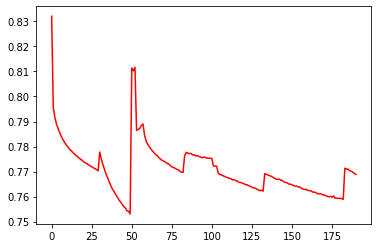

In [108]:
plt.plot(loss_list,color = 'r')
plt.savefig(model_path+"loss.png")

In [111]:
alphanet = alphanet.cpu()
pred_list = []
label_list = []
for _, (data, label) in enumerate(test_loader):
    data = Variable(data).float()
    pred = alphanet(data)
    pred_list.extend(pred.tolist())
    label_list.extend(label.tolist())

In [112]:
final = pd.DataFrame(pred_list)
final = pd.concat([target_list.reset_index(),final],axis=1)
final.rename(columns={0:Alpha_Name,'ticker': 'symbol'},inplace=True)
# final.set_index(["timestamp","symbol"],inplace=True)
final

,timestamp,symbol,target,AlphaNet_Original_Input_10d_return
0,2021-01-04 09:30:00,1,2.080068,-0.078908
1,2021-01-05 09:30:00,1,2.542624,0.019862
2,2021-01-06 09:30:00,1,2.731188,0.092040
3,2021-01-07 09:30:00,1,1.487784,0.000786
4,2021-01-08 09:30:00,1,0.894896,0.071132
...,...,...,...,...
402675,2021-05-25 09:30:00,688981,-0.262939,-0.062979
402676,2021-05-26 09:30:00,688981,-0.222002,-0.098845
402677,2021-05-27 09:30:00,688981,-0.212631,0.001484
402678,2021-05-28 09:30:00,688981,-0.232948,0.037301


In [113]:
final.to_parquet(output_path
                + test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1])